<!-- dom:TITLE: Data Analysis and Machine Learning: Getting started, our first data and Machine Learning encounters -->
# Esempi di Reti Neureali FF e back-propagation
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
<!-- dom:AUTHOR: Carlo Barbieri at Department of Physics, Università Statale di Milano -->
<!-- Author: -->  
Note adattate dal corso di  **Morten Hjorth-Jensen**, Dipartimento di fisica (Università di Oslo e Michigan State University).

C. Barbieri, $\qquad$ **Novembre 2020** (_versione preliminare_).


Metodi di discesa del gradiente (Gradient Descent) e discesa del gradiente stocastica (Stochastic Gradient Descent) in funzioni di molti parametri.



### Testi di riferimento

Il materiale discusso in queste lezioni è estratto da: [Aurelien Geron's capitoli 10-11](https://gitlab.com/craolus/MachineLearning-con-applicazioni/-/blob/master/Documenti/Monografie/TensorflowML.pdf) e dal capitolo 11 di *Hastie et*.



<!-- !split  -->
## Esempio di un codice per reti neurali di tipo feed-forward with back propagation


One can identify a set of key steps when using neural networks to solve supervised learning problems:  

1. Collect and pre-process data  

2. Define model and architecture  

3. Choose cost function and optimizer  

4. Train the model  

5. Evaluate model performance on test data  

6. Adjust hyperparameters (if necessary, network architecture)

## Raccolta e operazioni preliminari sui dati

In questo esempio useremo il dataset MNIST che è anche accessibile direttamente dalla libreria **scikit-learn**. I dati originali sono disponiobili su [questo sito](http://yann.lecun.com/exdb/mnist/).  Il *MNIST* (Modified National Institute of Standards and Technology) è un grosso database contenente immagini di numeri arabi scritti a mano e viene normalmente usato per l'addestramento di sistemi per la manipolazione delle immagini.  Il MNIST contiene 70 000 immagini di dimensioni pari a $28\times 28$ pixels, classificate con le cifre da 0 a 9.  Useremo un sottoinsieme disponibile in scikit-learn contenente una selezione di 1797 immagini di dimensioni $8\times 8$ che sono state selezionate (e ridotte in risoluzione) dal MNIST.  

Per utilizzare i dati in una rete neurale feed-forward (FFNN) dobbiamo rappresentare gli input
in termini di una matrice di design (o matrice delle caratteristiche) $X = (n_{inputs}, n_{features})$.  Ogni
riga rapresente l'*input* di un campionamento, in questo caso una cifra scritta a mano, e ogni colonna rappresenta una charatteristica (*feature*), in questo caso un pixel.  La riscposte corrette, anche dette etichette o classi (*labels* or *targets* in inglese) sono rappresentate come un vettore in 1D contenente i numeri interi di una cifra 
$Y = (n_{inputs}) = (5, 3, 1, 8,...)$.

Immaginiamo di voler costruire una rete enurale basata sul supervised learning per predirre l'indice di massa corporea (Body-Mass Index, BMI) in base alle misure del peso (in Kg) e dell'altezza (in m). Se si hanno 5 differenti campionamenti (ottenuti da altrettanti individui), la matrice di design potrebbe essere:

$$ X = \begin{bmatrix}
1.85 & 81\\
1.71 & 65\\
1.95 & 103\\
1.55 & 42\\
1.63 & 56
\end{bmatrix} ,$$  

ed i rispettivi valori del BMI:  

$$ Y = \begin{bmatrix} 23.7 \\ 22.2 \\ 27.1 \\ 17.5 \\ 21.1  \end{bmatrix} .$$  

Nell'esempio a sequire, ogni immagine in input è una matrice in 2D e dobbiamo 
mapparla sun un array in 1D (ovvero "appiattire" l'immagine)
per poi costruire la matrice di desing/matrice delle caratteristiche.
Questo implica che si perdano le alcune informazioni riguardo la distribuzione spaziale
dei pixel, come la vicinanza e l'invarianza traslazionale.
Architetture più sofisticate quali le reti neurali convoluzionali, sfruttano invece
queste informazioni al fine di opttimizzare l'analisi si immagini e altri set
di dati con correlazioni temporali e spaziali.

inputs = (n_inputs, pixel_width, pixel_height) = (1797, 8, 8)
labels = (n_inputs) = (1797,)
X = (n_inputs, n_features) = (1797, 64)


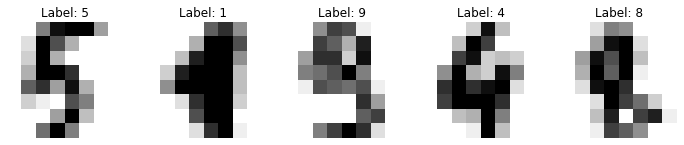

In [1]:
%matplotlib inline

# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# re-inizializza il generatore di numeri casuali, per avere ogni volta la stessa sequenza
np.random.seed(1)

# Per mostrare le immagini sul notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# carica il dataset di MNIST
digits = datasets.load_digits()

# definizioan degli inputs e dele labels
inputs = digits.images
labels = digits.target

print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print("X = (n_inputs, n_features) = " + str(inputs.shape))


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()

## Insiemi di dati per l'apprendimento e la verifica (train and test datasets)

Ricordiamoci che procedere all'analisi prima di aver partizionato il set di dati è un *grosso errore* che può 
portare a soluzioni sbagliate.

Separeremo l'$80 \%$ del dataset da destinare all'apprendimanto (fitting) e riserveremo il rimanente $20 \%$  per la verifica.


È importante ertrarre i dataset di *training* e *test* in maniera casuale, onde evitare potenziali bias nel campionamento. Per esempio: se si considerimo misure del metereologiche per predirre i tempo nei prossimi 5 giorni, non vogliamo fittare il modello sumisure prese tra la mezzanotte e le 12:00 per poi testarlo sui dati collezionati tra le 12:00 e le 24:00.

In [2]:
from sklearn.model_selection import train_test_split

# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

# equivalently in numpy
def train_test_split_numpy(inputs, labels, train_size, test_size):
    n_inputs = len(inputs)
    inputs_shuffled = inputs.copy()
    labels_shuffled = labels.copy()
    
    np.random.shuffle(inputs_shuffled)
    np.random.shuffle(labels_shuffled)
    
    train_end = int(n_inputs*train_size)
    X_train, X_test = inputs_shuffled[:train_end], inputs_shuffled[train_end:]
    Y_train, Y_test = labels_shuffled[:train_end], labels_shuffled[train_end:]
    
    return X_train, X_test, Y_train, Y_test

#X_train, X_test, Y_train, Y_test = train_test_split_numpy(inputs, labels, train_size, test_size)

print("Number of training images: " + str(len(X_train)))
print("Number of test images: " + str(len(X_test)))

Number of training images: 1437
Number of test images: 360


## Definizone del modello e dell'architettura

Our simple feed-forward neural network will consist of an *input* layer, a single *hidden* layer and an *output* layer. The activation $y$ of each neuron is a weighted sum of inputs, passed through an activation function. In case of the simple perceptron model we have 

$$ z = \sum_{i=1}^n w_i a_i ,$$

$$ y = f(z) ,$$

where $f$ is the activation function, $a_i$ represents input from neuron $i$ in the preceding layer
and $w_i$ is the weight to input $i$.  
The activation of the neurons in the input layer is just the features (e.g. a pixel value).  

The simplest activation function for a neuron is the *Heaviside* function:

$$ f(z) = 
\begin{cases}
1,  &  z > 0\\
0,  & \text{otherwise}
\end{cases}
$$

A feed-forward neural network with this activation is known as a *perceptron*.  
For a binary classifier (i.e. two classes, 0 or 1, dog or not-dog) we can also use this in our output layer.  
This activation can be generalized to $k$ classes (using e.g. the *one-against-all* strategy), 
and we call these architectures *multiclass perceptrons*.  

However, it is now common to use the terms Single Layer Perceptron (SLP) (1 hidden layer) and  
Multilayer Perceptron (MLP) (2 or more hidden layers) to refer to feed-forward neural networks with any activation function.  

Typical choices for activation functions include the sigmoid function, hyperbolic tangent, and Rectified Linear Unit (ReLU).  
We will be using the sigmoid function $\sigma(x)$:  

$$ f(x) = \sigma(x) = \frac{1}{1 + e^{-x}} ,$$

which is inspired by probability theory (see logistic regression) and was most commonly used until about 2011. See the discussion below concerning other activation functions.

<!-- !split   -->
## Strati

* Valori di ingresso (input layer)

Since each input image has 8x8 = 64 pixels or features, we have an input layer of 64 neurons.  

* Strati nascosti (hidden layer(s))

We will use 50 neurons in the hidden layer receiving input from the neurons in the input layer.  
Since each neuron in the hidden layer is connected to the 64 inputs we have 64x50 = 3200 weights to the hidden layer.  

* Risultati (output layer)

If we were building a binary classifier, it would be sufficient with a single neuron in the output layer,
which could output 0 or 1 according to the Heaviside function. This would be an example of a *hard* classifier, meaning it outputs the class of the input directly. However, if we are dealing with noisy data it is often beneficial to use a *soft* classifier, which outputs the probability of being in class 0 or 1.  

For a soft binary classifier, we could use a single neuron and interpret the output as either being the probability of being in class 0 or the probability of being in class 1. Alternatively we could use 2 neurons, and interpret each neuron as the probability of being in each class.  

Since we are doing multiclass classification, with 10 categories, it is natural to use 10 neurons in the output layer. We number the neurons $j = 0,1,...,9$. The activation of each output neuron $j$ will be according to the *softmax* function:  

$$ P(\text{class $j$} \mid \text{input $\hat{a}$}) = \frac{\exp{(\hat{a}^T \hat{w}_j)}}
{\sum_{c=0}^{9} \exp{(\hat{a}^T \hat{w}_c)}} ,$$  

i.e. each neuron $j$ outputs the probability of being in class $j$ given an input from the hidden layer $\hat{a}$, with $\hat{w}_j$ the weights of neuron $j$ to the inputs.  
The denominator is a normalization factor to ensure the outputs (probabilities) sum up to 1.  
The exponent is just the weighted sum of inputs as before:  

$$ z_j = \sum_{i=1}^n w_ {ij} a_i+b_j.$$  

Since each neuron in the output layer is connected to the 50 inputs from the hidden layer we have 50x10 = 500
weights to the output layer.

<!-- !split   -->
## Weights and biases

Typically weights are initialized with small values distributed around zero, drawn from a uniform
or normal distribution. Setting all weights to zero means all neurons give the same output, making the network useless.  

Adding a bias value to the weighted sum of inputs allows the neural network to represent a greater range
of values. Without it, any input with the value 0 will be mapped to zero (before being passed through the activation). The bias unit has an output of 1, and a weight to each neuron $j$, $b_j$:  

$$ z_j = \sum_{i=1}^n w_ {ij} a_i + b_j.$$  

The bias weights $\hat{b}$ are often initialized to zero, but a small value like $0.01$ ensures all neurons have some output which can be backpropagated in the first training cycle.

In [3]:
# building our neural network

n_inputs, n_features = X_train.shape
n_hidden_neurons = 50
n_categories = 10

# we make the weights normally distributed using numpy.random.randn

# weights and bias in the hidden layer
hidden_weights = np.random.randn(n_features, n_hidden_neurons)
hidden_bias = np.zeros(n_hidden_neurons) + 0.01

# weights and bias in the output layer
output_weights = np.random.randn(n_hidden_neurons, n_categories)
output_bias = np.zeros(n_categories) + 0.01

## Feed-forward pass

Denote $F$ the number of features, $H$ the number of hidden neurons and $C$ the number of categories.  
For each input image we calculate a weighted sum of input features (pixel values) to each neuron $j$ in the hidden layer $l$:  

$$ z_{j}^{l} = \sum_{i=1}^{F} w_{ij}^{l} x_i + b_{j}^{l},$$

this is then passed through our activation function  

$$ a_{j}^{l} = f(z_{j}^{l}) .$$  

We calculate a weighted sum of inputs (activations in the hidden layer) to each neuron $j$ in the output layer:  

$$ z_{j}^{L} = \sum_{i=1}^{H} w_{ij}^{L} a_{i}^{l} + b_{j}^{L}.$$  

Finally we calculate the output of neuron $j$ in the output layer using the softmax function:  

$$ a_{j}^{L} = \frac{\exp{(z_j^{L})}}
{\sum_{c=0}^{C-1} \exp{(z_c^{L})}} .$$  

<!-- !split    -->
## Matrix multiplications

Since our data has the dimensions $X = (n_{inputs}, n_{features})$ and our weights to the hidden
layer have the dimensions  
$W_{hidden} = (n_{features}, n_{hidden})$,
we can easily feed the network all our training data in one go by taking the matrix product  

$$ X W^{h} = (n_{inputs}, n_{hidden}),$$ 

and obtain a matrix that holds the weighted sum of inputs to the hidden layer
for each input image and each hidden neuron.    
We also add the bias to obtain a matrix of weighted sums to the hidden layer $Z^{h}$:  

$$ \hat{z}^{l} = \hat{X} \hat{W}^{l} + \hat{b}^{l} ,$$

dove $l$ si riferisce alla $l$-esima colonna della matrice $\hat{X} \hat{W}$ (che da il valore del $l$-esimo neurone latente per ogni dato campionato) e $\hat{b}^{l}$ è il bias del neurone corrispondente. Ovvero: the same bias (1D array with size equal number of hidden neurons) is added to each input image.  
This is then passed through the activation:  

$$ \hat{a}^{l} = f(\hat{z}^l) .$$  

This is fed to the output layer:  

$$ \hat{z}^{L} = \hat{a}^{L} \hat{W}^{L} + \hat{b}^{L} .$$

Finally we receive our output values for each image and each category by passing it through the softmax function:  

$$ output = softmax (\hat{z}^{L}) = (n_{inputs}, n_{categories}) .$$

In [4]:
# setup the feed-forward pass, subscript h = hidden layer

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def feed_forward(X):
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = sigmoid(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights) + output_bias
    # softmax output
    # axis 0 holds each input and axis 1 the probabilities of each category
    exp_term = np.exp(z_o)
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    
    return probabilities

probabilities = feed_forward(X_train)
print("probabilities = (n_inputs, n_categories) = " + str(probabilities.shape))
print("probability that image 0 is in category 0,1,2,...,9 = \n" + str(probabilities[0]))
print("probabilities sum up to: " + str(probabilities[0].sum()))
print()

# we obtain a prediction by taking the class with the highest likelihood
def predict(X):
    probabilities = feed_forward(X)
    return np.argmax(probabilities, axis=1)

predictions = predict(X_train)
print("predictions = (n_inputs) = " + str(predictions.shape))
print("prediction for image 0: " + str(predictions[0]))
print("correct label for image 0: " + str(Y_train[0]))

probabilities = (n_inputs, n_categories) = (1437, 10)
probability that image 0 is in category 0,1,2,...,9 = 
[3.83415383e-01 1.65528357e-04 5.40430664e-01 1.23006404e-07
 1.75367730e-04 2.23032795e-02 8.10851045e-03 1.24794605e-02
 2.91640938e-02 3.75758980e-03]
probabilities sum up to: 1.0

predictions = (n_inputs) = (1437,)
prediction for image 0: 2
correct label for image 0: 9


## Scelta della funzione di costo e dell'ottimizzatore

To measure how well our neural network is doing we need to introduce a cost function.  
We will call the function that gives the error of a single sample output the *loss* function, and the function
that gives the total error of our network across all samples the *cost* function.
A typical choice for multiclass classification is the *cross-entropy* loss, also known as the negative log likelihood.  

In *multiclass* classification it is common to treat each integer label as a so called *one-hot* vector:  

$$ y = 5 \quad \rightarrow \quad \hat{y} = (0, 0, 0, 0, 0, 1, 0, 0, 0, 0) ,$$  


$$ y = 1 \quad \rightarrow \quad \hat{y} = (0, 1, 0, 0, 0, 0, 0, 0, 0, 0) ,$$  


i.e. a binary bit string of length $C$, where $C = 10$ is the number of classes in the MNIST dataset.  

Let $y_{ic}$ denote the $c$-th component of the $i$-th one-hot vector.  
We define the cost function $\mathcal{C}$ as a sum over the cross-entropy loss for each point $\hat{x}_i$ in the dataset.

In the one-hot representation only one of the terms in the loss function is non-zero, namely the
probability of the correct category $c'$  
(i.e. the category $c'$ such that $y_{ic'} = 1$). This means that the cross entropy loss only punishes you for how wrong
you got the correct label. The probability of category $c$ is given by the softmax function. The vector $\hat{\theta}$ represents the parameters of our network, i.e. all the weights and biases.  


## Ottimizzaqzione della funzione di costo

The network is trained by finding the weights and biases that minimize the cost function. One of the most widely used classes of methods is *gradient descent* and its generalizations. The idea behind gradient descent
is simply to adjust the weights in the direction where the gradient of the cost function is large and negative. This ensures we flow toward a *local* minimum of the cost function.  
Each parameter $\theta$ is iteratively adjusted according to the rule  

$$ \theta_{i+1} = \theta_i - \eta \nabla \mathcal{C}(\theta_i) ,$$

where $\eta$ is known as the *learning rate*, which controls how big a step we take towards the minimum.  
This update can be repeated for any number of iterations, or until we are satisfied with the result.  

A simple and effective improvement is a variant called *Batch Gradient Descent*.  
Instead of calculating the gradient on the whole dataset, we calculate an approximation of the gradient
on a subset of the data called a *minibatch*.  
If there are $N$ data points and we have a minibatch size of $M$, the total number of batches
is $N/M$.  
We denote each minibatch $B_k$, with $k = 1, 2,...,N/M$. The gradient then becomes:  

$$ \nabla \mathcal{C}(\theta) = \frac{1}{N} \sum_{i=1}^N \nabla \mathcal{L}_i(\theta) \quad \rightarrow \quad
\frac{1}{M} \sum_{i \in B_k} \nabla \mathcal{L}_i(\theta) ,$$

i.e. instead of averaging the loss over the entire dataset, we average over a minibatch.  

This has two important benefits:  
1. Introducing stochasticity decreases the chance that the algorithm becomes stuck in a local minima.  

2. It significantly speeds up the calculation, since we do not have to use the entire dataset to calculate the gradient.  

The various optmization  methods, with codes and algorithms,  are discussed in our lectures on [Gradient descent approaches](https://compphysics.github.io/MachineLearning/doc/pub/Splines/html/Splines-bs.html).

<!-- !split   -->
## Regolarizzazione

It is common to add an extra term to the cost function, proportional
to the size of the weights.  This is equivalent to constraining the
size of the weights, so that they do not grow out of control.
Constraining the size of the weights means that the weights cannot
grow arbitrarily large to fit the training data, and in this way
reduces *overfitting*.

We will measure the size of the weights using the so called *L2-norm*, meaning our cost function becomes:  

$$  \mathcal{C}(\theta) = \frac{1}{N} \sum_{i=1}^N \mathcal{L}_i(\theta) \quad \rightarrow \quad
\frac{1}{N} \sum_{i=1}^N  \mathcal{L}_i(\theta) + \lambda \lvert \lvert \hat{w} \rvert \rvert_2^2 
= \frac{1}{N} \sum_{i=1}^N  \mathcal{L}(\theta) + \lambda \sum_{ij} w_{ij}^2,$$  

i.e. we sum up all the weights squared. The factor $\lambda$ is known as a regularization parameter.


In order to train the model, we need to calculate the derivative of
the cost function with respect to every bias and weight in the
network.  In total our network has $(64 + 1)\times 50=3250$ weights in
the hidden layer and $(50 + 1)\times 10=510$ weights to the output
layer ($+1$ for the bias), and the gradient must be calculated for
every parameter.  We use the *backpropagation* algorithm discussed
above. This is a clever use of the chain rule that allows us to
calculate the gradient efficently. 


## Moltiplicazione tra matrici

To more efficently train our network these equations are implemented using matrix operations.  
The error in the output layer is calculated simply as, with $\hat{t}$ being our targets,  

$$ \delta_L = \hat{t} - \hat{y} = (n_{inputs}, n_{categories}) .$$  

The gradient for the output weights is calculated as  

$$ \nabla W_{L} = \hat{a}^T \delta_L   = (n_{hidden}, n_{categories}) ,$$

where $\hat{a} = (n_{inputs}, n_{hidden})$. This simply means that we are summing up the gradients for each input.  
Since we are going backwards we have to transpose the activation matrix.  

The gradient with respect to the output bias is then  

$$ \nabla \hat{b}_{L} = \sum_{i=1}^{n_{inputs}} \delta_L = (n_{categories}) .$$  

The error in the hidden layer is  

$$ \Delta_h = \delta_L W_{L}^T \circ f'(z_{h}) = \delta_L W_{L}^T \circ a_{h} \circ (1 - a_{h}) = (n_{inputs}, n_{hidden}) ,$$  

where $f'(a_{h})$ is the derivative of the activation in the hidden layer. The matrix products mean
that we are summing up the products for each neuron in the output layer. The symbol $\circ$ denotes
the *Hadamard product*, meaning element-wise multiplication.  

This again gives us the gradients in the hidden layer:  

$$ \nabla W_{h} = X^T \delta_h = (n_{features}, n_{hidden}) ,$$  

$$ \nabla b_{h} = \sum_{i=1}^{n_{inputs}} \delta_h = (n_{hidden}) .$$

<!-- !split   -->
Nel seguito si fa una seria di passaggi della rete neurale, includendo il back-propagation, per vedere come cambia la funzione di costo dopo 1000 passi:

In [5]:
# to categorical turns our integer vector into a one-hot representation
from sklearn.metrics import accuracy_score

# one-hot in numpy
def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

#Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)
Y_train_onehot, Y_test_onehot = to_categorical_numpy(Y_train), to_categorical_numpy(Y_test)

def feed_forward_train(X):
    ##  se n==numero campionamenty, p==numero di features  e  h==numero di neutroni nascosti:
    ##   z_h[n,h],  X[n,p],   W[p,h]    b[h]
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = sigmoid(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights) + output_bias
    # softmax output
    # axis 0 holds each input and axis 1 the probabilities of each category
    exp_term = np.exp(z_o)
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    
    # for backpropagation need activations in hidden and output layers
    return a_h, probabilities

def backpropagation(X, Y):
    a_h, probabilities = feed_forward_train(X)
    
    # error in the output layer
    error_output = probabilities - Y
    # error in the hidden layer
    error_hidden = np.matmul(error_output, output_weights.T) * a_h * (1 - a_h)
    
    # gradients for the output layer
    output_weights_gradient = np.matmul(a_h.T, error_output)
    output_bias_gradient = np.sum(error_output, axis=0)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.matmul(X.T, error_hidden)
    hidden_bias_gradient = np.sum(error_hidden, axis=0)

    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient

print("Old accuracy on training data: " + str(accuracy_score(predict(X_train), Y_train)))

eta = 0.01
lmbd = 0.01
for i in range(1000):
    # calculate gradients
    dWo, dBo, dWh, dBh = backpropagation(X_train, Y_train_onehot)
    
    # regularization term gradients
    dWo += lmbd * output_weights
    dWh += lmbd * hidden_weights
    
    # update weights and biases
    output_weights -= eta * dWo
    output_bias -= eta * dBo
    hidden_weights -= eta * dWh
    hidden_bias -= eta * dBh

print("New accuracy on training data: " + str(accuracy_score(predict(X_train), Y_train)))

Old accuracy on training data: 0.08907446068197634
New accuracy on training data: 0.09742519137091162


## Improving performance

As we can see the network does not seem to be learning at all. It seems to be just guessing the label for each image.  
In order to obtain a network that does something useful, we will have to do a bit more work.  

The choice of *hyperparameters* such as learning rate and regularization parameter is hugely influential for the performance of the network. Typically a *grid-search* is performed, wherein we test different hyperparameters separated by orders of magnitude. For example we could test the learning rates $\eta = 10^{-6}, 10^{-5},...,10^{-1}$ with different regularization parameters $\lambda = 10^{-6},...,10^{-0}$.  

Next, we haven't implemented minibatching yet, which introduces stochasticity and is though to act as an important regularizer on the weights. We call a feed-forward + backward pass with a minibatch an *iteration*, and a full training period
going through the entire dataset ($n/M$ batches) an *epoch*.

If this does not improve network performance, you may want to consider altering the network architecture, adding more neurons or hidden layers.  
Andrew Ng goes through some of these considerations in this [video](https://youtu.be/F1ka6a13S9I). You can find a summary of the video [here](https://kevinzakka.github.io/2016/09/26/applying-deep-learning/).  

## Full object-oriented implementation

It is very natural to think of the network as an object, with specific instances of the network
being realizations of this object with different hyperparameters. An implementation using Python classes provides a clean structure and interface, and the full implementation of our neural network is given below.

In [6]:
class NeuralNetwork:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=50,
            n_categories=10,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()

    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) + 0.01

        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros(self.n_categories) + 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h = np.matmul(self.X_data, self.hidden_weights) + self.hidden_bias
        self.a_h = sigmoid(self.z_h)

        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias

        exp_term = np.exp(self.z_o)
        self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = sigmoid(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        
        exp_term = np.exp(z_o)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities

    def backpropagation(self):
        error_output = self.probabilities - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h * (1 - self.a_h)

        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights

        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()

## Evaluate model performance on test data

To measure the performance of our network we evaluate how well it does it data it has never seen before, i.e. the test data.  
We measure the performance of the network using the *accuracy* score.  
The accuracy is as you would expect just the number of images correctly labeled divided by the total number of images. A perfect classifier will have an accuracy score of $1$.  

$$ \text{Accuracy} = \frac{\sum_{i=1}^n I(\hat{y}_i = y_i)}{n} ,$$  

where $I$ is the indicator function, $1$ if $\hat{y}_i = y_i$ and $0$ otherwise.

In [7]:
epochs = 100
batch_size = 100

dnn = NeuralNetwork(X_train, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                    n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)
dnn.train()
test_predict = dnn.predict(X_test)

# accuracy score from scikit library
print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))

# equivalent in numpy
def accuracy_score_numpy(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

#print("Accuracy score on test set: ", accuracy_score_numpy(Y_test, test_predict))

Accuracy score on test set:  0.9611111111111111


## Aggiustamento degli iperparametri

A questo punto i valori della volecità di apprendimento ($\eta$) e dell parametro di regolarizzazione ($\lambda$) rimangono indefiniti e l'efficienza della rete può dipendere anche dalla scelta di questi.
Qui sotto, costriumo una griglia per cercarne i valori ottimali nel caso della nostra rete neurale.

Si noti che stiamo usando solo 1 strato con 50 neuroni e che l'efficienza umana per questo test è stimata attorno al  $98\%$ (ovvero un errore del $2\%$).

In [8]:
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
# store the models for later use
DNN_numpy = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

# grid search
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = NeuralNetwork(X_train, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                            n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(X_test)
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))
        print()

Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.075

Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.19444444444444445

Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.20833333333333334

Learning rate  =  1e-05
Lambda =  0.01
Accuracy score on test set:  0.2222222222222222

Learning rate  =  1e-05
Lambda =  0.1
Accuracy score on test set:  0.17222222222222222

Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.175

Learning rate  =  1e-05
Lambda =  10.0
Accuracy score on test set:  0.21944444444444444

Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.6055555555555555

Learning rate  =  0.0001
Lambda =  0.0001
Accuracy score on test set:  0.5833333333333334

Learning rate  =  0.0001
Lambda =  0.001
Accuracy score on test set:  0.4777777777777778

Learning rate  =  0.0001
Lambda =  0.01
Accuracy score on test set:  0.5833333333333334

Learning rate  =  0.0001
Lambda =  0.1
Accur

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Learning rate  =  1.0
Lambda =  1e-05
Accuracy score on test set:  0.11388888888888889

Learning rate  =  1.0
Lambda =  0.0001
Accuracy score on test set:  0.11388888888888889

Learning rate  =  1.0
Lambda =  0.001
Accuracy score on test set:  0.11388888888888889

Learning rate  =  1.0
Lambda =  0.01
Accuracy score on test set:  0.11388888888888889

Learning rate  =  1.0
Lambda =  0.1
Accuracy score on test set:  0.11388888888888889

Learning rate  =  1.0
Lambda =  1.0
Accuracy score on test set:  0.1111111111111111

Learning rate  =  1.0
Lambda =  10.0
Accuracy score on test set:  0.11388888888888889

Learning rate  =  10.0
Lambda =  1e-05
Accuracy score on test set:  0.11388888888888889

Learning rate  =  10.0
Lambda =  0.0001
Accuracy score on test set:  0.11388888888888889

Learning rate  =  10.0
Lambda =  0.001
Accuracy score on test set:  0.11388888888888889

Learning rate  =  10.0
Lambda =  0.01
Accuracy score on test set:  0.11388888888888889

Learning rate  =  10.0
Lambda =  0

## Visualization

$\eta\sim$3 e $\lambda<$3 risultano essere i valri ottimali con cira il $94\%$ di efficienza sul dataset ti test (notare che il training dà il $100\%$ ma questò non è l'errore vero).

Usiamo al libreria *seaborn* per visualizzare una 'heat map' de questi risultati:

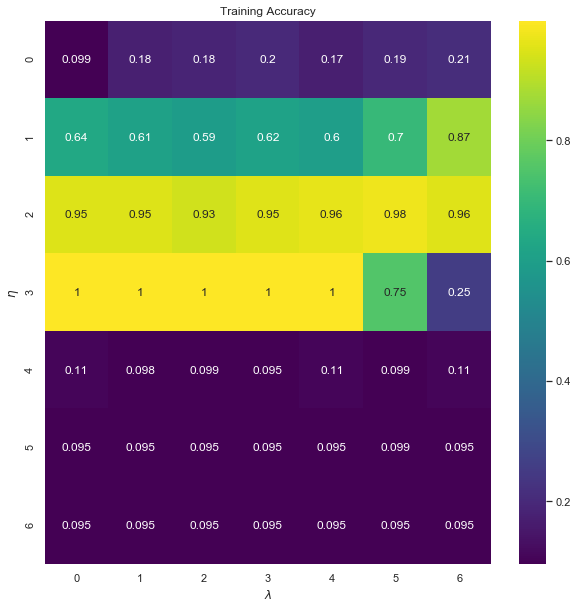

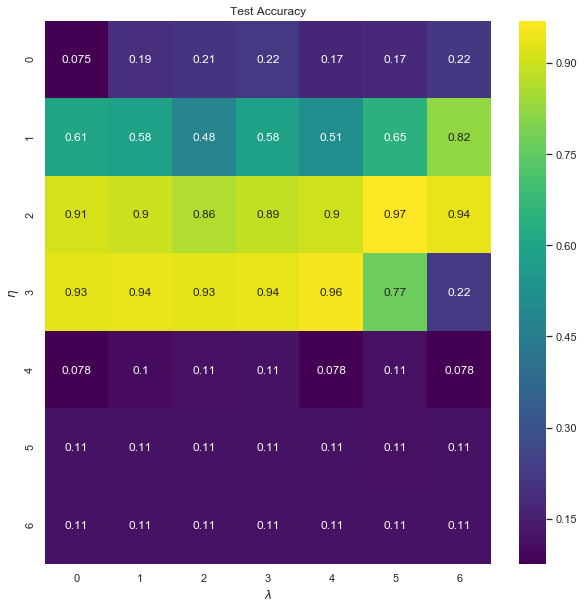

In [9]:
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_accuracy[i][j] = accuracy_score(Y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(Y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

## scikit-learn implementation

**scikit-learn** focuses more
on traditional machine learning methods, such as regression,
clustering, decision trees, etc. As such, it has only two types of
neural networks: Multi Layer Perceptron outputting continuous values,
*MPLRegressor*, and Multi Layer Perceptron outputting labels,
*MLPClassifier*. We will see how simple it is to use these classes.

**scikit-learn** implements a few improvements from our neural network,
such as early stopping, a varying learning rate, different
optimization methods, etc. We would therefore expect a better
performance overall.

In [10]:
from sklearn.neural_network import MLPClassifier
# store models for later use
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        
        DNN_scikit[i][j] = dnn
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", dnn.score(X_test, Y_test))
        print()

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.2638888888888889



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.15555555555555556



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.16666666666666666



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.01
Accuracy score on test set:  0.16111111111111112



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.1
Accuracy score on test set:  0.19722222222222222



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.16944444444444445



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  10.0
Accuracy score on test set:  0.3138888888888889



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.8944444444444445



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.0001
Accuracy score on test set:  0.8833333333333333



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.001
Accuracy score on test set:  0.8833333333333333



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.01
Accuracy score on test set:  0.9



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.1
Accuracy score on test set:  0.875



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  1.0
Accuracy score on test set:  0.8861111111111111



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  10.0
Accuracy score on test set:  0.8666666666666667



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  1e-05
Accuracy score on test set:  0.9805555555555555



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.0001
Accuracy score on test set:  0.9833333333333333



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.001
Accuracy score on test set:  0.9805555555555555



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.01
Accuracy score on test set:  0.9777777777777777



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.1
Accuracy score on test set:  0.9777777777777777



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  1.0
Accuracy score on test set:  0.9722222222222222



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  10.0
Accuracy score on test set:  0.9416666666666667

Learning rate  =  0.01
Lambda =  1e-05
Accuracy score on test set:  0.9833333333333333



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  0.0001
Accuracy score on test set:  0.9833333333333333



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  0.001
Accuracy score on test set:  0.9805555555555555



/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  0.01
Accuracy score on test set:  0.9833333333333333

Learning rate  =  0.01
Lambda =  0.1
Accuracy score on test set:  0.975

Learning rate  =  0.01
Lambda =  1.0
Accuracy score on test set:  0.9666666666666667

Learning rate  =  0.01
Lambda =  10.0
Accuracy score on test set:  0.9277777777777778

Learning rate  =  0.1
Lambda =  1e-05
Accuracy score on test set:  0.9222222222222223

Learning rate  =  0.1
Lambda =  0.0001
Accuracy score on test set:  0.9138888888888889

Learning rate  =  0.1
Lambda =  0.001
Accuracy score on test set:  0.9333333333333333

Learning rate  =  0.1
Lambda =  0.01
Accuracy score on test set:  0.9166666666666666

Learning rate  =  0.1
Lambda =  0.1
Accuracy score on test set:  0.8972222222222223

Learning rate  =  0.1
Lambda =  1.0
Accuracy score on test set:  0.9277777777777778

Learning rate  =  0.1
Lambda =  10.0
Accuracy score on test set:  0.8555555555555555

Learning rate  =  1.0
Lambda =  1e-05
Accuracy score on test se

## Visualization

***scikit-learn*** è più efficiente e raggiunge precisioni del 97-98$\%$ per $\eta=$2-3 e $\lambda<$4:

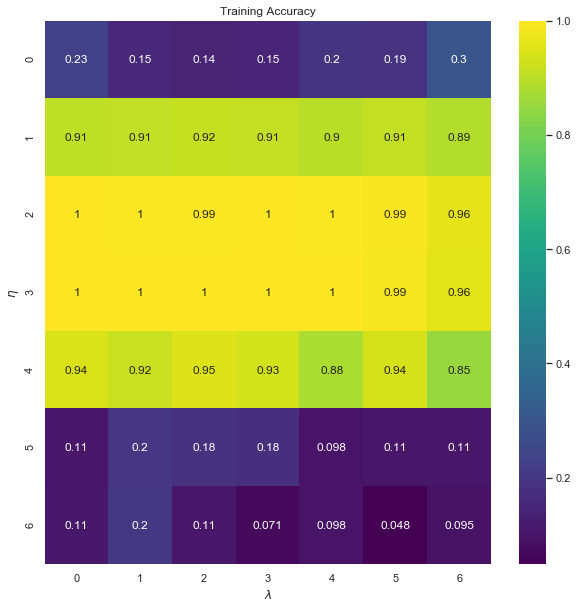

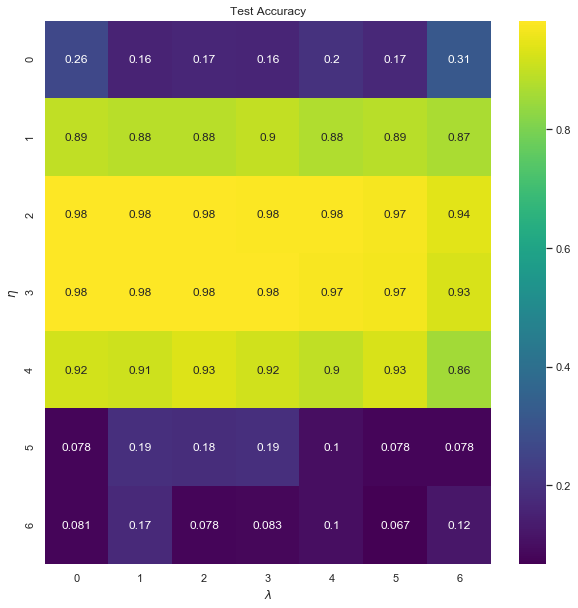

In [11]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_scikit[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_accuracy[i][j] = accuracy_score(Y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(Y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

## Costruzione di reti neurali usando le librerie di Tensorflow and Keras

Now we want  to build on the experience gained from our neural network implementation in NumPy and scikit-learn
and use it to construct a neural network in Tensorflow. Once we have constructed a neural network in NumPy
and Tensorflow, building one in Keras is really quite trivial, though the performance may suffer.  

In our previous example we used only one hidden layer, and in this we will use two. From this it should be quite
clear how to build one using an arbitrary number of hidden layers, using data structures such as Python lists or
NumPy arrays.

## Tensorflow

Tensorflow is an open source library machine learning library
developed by the Google Brain team for internal use. It was released
under the Apache 2.0 open source license in November 9, 2015.

Tensorflow is a computational framework that allows you to construct
machine learning models at different levels of abstraction, from
high-level, object-oriented APIs like Keras, down to the C++ kernels
that Tensorflow is built upon. The higher levels of abstraction are
simpler to use, but less flexible, and our choice of implementation
should reflect the problems we are trying to solve.

[Tensorflow uses](https://www.tensorflow.org/guide/graphs) so-called graphs to represent your computation
in terms of the dependencies between individual operations, such that you first build a Tensorflow *graph*
to represent your model, and then create a Tensorflow *session* to run the graph.

In this guide we will analyze the same data as we did in our NumPy and
scikit-learn tutorial, gathered from the MNIST database of images. We
will give an introduction to the lower level Python Application
Program Interfaces (APIs), and see how we use them to build our graph.
Then we will build (effectively) the same graph in Keras, to see just
how simple solving a machine learning problem can be.

To install tensorflow on Unix/Linux systems, use pip as

In [12]:
pip3 install tensorflow

SyntaxError: invalid syntax (<ipython-input-12-6ea927cc6e88>, line 1)

and/or if you use **anaconda**, just write (or install from the graphical user interface)
(current release of CPU-only TensorFlow)

In [ ]:
conda create -n tf tensorflow
conda activate tf

To install the current release of GPU TensorFlow

In [ ]:
conda create -n tf-gpu tensorflow-gpu
conda activate tf-gpu

## Using Keras

Keras is a high level [neural network](https://en.wikipedia.org/wiki/Application_programming_interface)
that supports Tensorflow, CTNK and Theano as backends.  
If you have Anaconda installed you may run the following command

In [ ]:
conda install keras

You can look up the [instructions here](https://keras.io/) for more information.

We will to a large extent use **keras** in this course. 

## Collect and pre-process data

Let us look again at the MINST data set.

In [ ]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets


# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print("X = (n_inputs, n_features) = " + str(inputs.shape))


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function

from sklearn.model_selection import train_test_split

# one-hot representation of labels
labels = to_categorical(labels)

# split into train and test data
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

In [ ]:

epochs = 100
batch_size = 100
n_neurons_layer1 = 100
n_neurons_layer2 = 50
n_categories = 10
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
def create_neural_network_keras(n_neurons_layer1, n_neurons_layer2, n_categories, eta, lmbd):
    model = Sequential()
    model.add(Dense(n_neurons_layer1, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(n_neurons_layer2, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(n_categories, activation='softmax'))
    
    sgd = optimizers.SGD(lr=eta)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

In [ ]:
DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = create_neural_network_keras(n_neurons_layer1, n_neurons_layer2, n_categories,
                                         eta=eta, lmbd=lmbd)
        DNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        scores = DNN.evaluate(X_test, Y_test)
        
        DNN_keras[i][j] = DNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print()

In [ ]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        DNN = DNN_keras[i][j]

        train_accuracy[i][j] = DNN.evaluate(X_train, Y_train)[1]
        test_accuracy[i][j] = DNN.evaluate(X_test, Y_test)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

## The Breast Cancer Data, now with Keras

In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as splitter
from sklearn.datasets import load_breast_cancer
import pickle
import os 


"""Load breast cancer dataset"""

np.random.seed(0)        #create same seed for random number every time

cancer=load_breast_cancer()      #Download breast cancer dataset

inputs=cancer.data                     #Feature matrix of 569 rows (samples) and 30 columns (parameters)
outputs=cancer.target                  #Label array of 569 rows (0 for benign and 1 for malignant)
labels=cancer.feature_names[0:30]

print('The content of the breast cancer dataset is:')      #Print information about the datasets
print(labels)
print('-------------------------')
print("inputs =  " + str(inputs.shape))
print("outputs =  " + str(outputs.shape))
print("labels =  "+ str(labels.shape))

x=inputs      #Reassign the Feature and Label matrices to other variables
y=outputs

#%% 

# Visualisation of dataset (for correlation analysis)

plt.figure()
plt.scatter(x[:,0],x[:,2],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean radius',fontweight='bold')
plt.ylabel('Mean perimeter',fontweight='bold')
plt.show()

plt.figure()
plt.scatter(x[:,5],x[:,6],s=40,c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean compactness',fontweight='bold')
plt.ylabel('Mean concavity',fontweight='bold')
plt.show()


plt.figure()
plt.scatter(x[:,0],x[:,1],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean radius',fontweight='bold')
plt.ylabel('Mean texture',fontweight='bold')
plt.show()

plt.figure()
plt.scatter(x[:,2],x[:,1],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean perimeter',fontweight='bold')
plt.ylabel('Mean compactness',fontweight='bold')
plt.show()


# Generate training and testing datasets

#Select features relevant to classification (texture,perimeter,compactness and symmetery) 
#and add to input matrix

temp1=np.reshape(x[:,1],(len(x[:,1]),1))
temp2=np.reshape(x[:,2],(len(x[:,2]),1))
X=np.hstack((temp1,temp2))      
temp=np.reshape(x[:,5],(len(x[:,5]),1))
X=np.hstack((X,temp))       
temp=np.reshape(x[:,8],(len(x[:,8]),1))
X=np.hstack((X,temp))       

X_train,X_test,y_train,y_test=splitter(X,y,test_size=0.1)   #Split datasets into training and testing

y_train=to_categorical(y_train)     #Convert labels to categorical when using categorical cross entropy
y_test=to_categorical(y_test)

del temp1,temp2,temp

# %%

# Define tunable parameters"

eta=np.logspace(-3,-1,3)                    #Define vector of learning rates (parameter to SGD optimiser)
lamda=0.01                                  #Define hyperparameter
n_layers=2                                  #Define number of hidden layers in the model
n_neuron=np.logspace(0,3,4,dtype=int)       #Define number of neurons per layer
epochs=100                                   #Number of reiterations over the input data
batch_size=100                              #Number of samples per gradient update

# %%

"""Define function to return Deep Neural Network model"""

def NN_model(inputsize,n_layers,n_neuron,eta,lamda):
    model=Sequential()      
    for i in range(n_layers):       #Run loop to add hidden layers to the model
        if (i==0):                  #First layer requires input dimensions
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda),input_dim=inputsize))
        else:                       #Subsequent layers are capable of automatic shape inferencing
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda)))
    model.add(Dense(2,activation='softmax'))  #2 outputs - ordered and disordered (softmax for prob)
    sgd=optimizers.SGD(lr=eta)
    model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
    return model

    
Train_accuracy=np.zeros((len(n_neuron),len(eta)))      #Define matrices to store accuracy scores as a function
Test_accuracy=np.zeros((len(n_neuron),len(eta)))       #of learning rate and number of hidden neurons for 

for i in range(len(n_neuron)):     #run loops over hidden neurons and learning rates to calculate 
    for j in range(len(eta)):      #accuracy scores 
        DNN_model=NN_model(X_train.shape[1],n_layers,n_neuron[i],eta[j],lamda)
        DNN_model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1)
        Train_accuracy[i,j]=DNN_model.evaluate(X_train,y_train)[1]
        Test_accuracy[i,j]=DNN_model.evaluate(X_test,y_test)[1]
               

def plot_data(x,y,data,title=None):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)
    if title is not None:
        ax.set_title(title)

    plt.tight_layout()

    plt.show()
    
plot_data(eta,n_neuron,Train_accuracy, 'training')
plot_data(eta,n_neuron,Test_accuracy, 'testing')

## Fine-tuning neural network hyperparameters

The flexibility of neural networks is also one of their main
drawbacks: there are many hyperparameters to tweak. Not only can you
use any imaginable network topology (how neurons/nodes are interconnected),
but even in a simple FFNN you can change the number of layers, the
number of neurons per layer, the type of activation function to use in
each layer, the weight initialization logic, the stochastic gradient optmized and much more. How do you
know what combination of hyperparameters is the best for your task?

* You can use grid search with cross-validation to find the right hyperparameters.

However,since there are many hyperparameters to tune, and since
training a neural network on a large dataset takes a lot of time, you
will only be able to explore a tiny part of the hyperparameter space.


* You can use randomized search.

* Or use tools like [Oscar](http://oscar.calldesk.ai/), which implements more complex algorithms to help you find a good set of hyperparameters quickly.  

## Hidden layers



For many problems you can start with just one or two hidden layers and it will work just fine.
For the MNIST data set you ca easily get a high accuracy using just one hidden layer with a
few hundred neurons.
You can reach for this data set above 98% accuracy using two hidden layers with the same total amount of
neurons, in roughly the same amount of training time. 

For more complex problems, you can gradually
ramp up the number of hidden layers, until you start overfitting the training set. Very complex tasks, such
as large image classification or speech recognition, typically require networks with dozens of layers
and they need a huge amount
of training data. However, you will rarely have to train such networks from scratch: it is much more
common to reuse parts of a pretrained state-of-the-art network that performs a similar task.




<!-- !split  -->
## Which activation function should I use?

The Back propagation algorithm we derived above works by going from
the output layer to the input layer, propagating the error gradient on
the way. Once the algorithm has computed the gradient of the cost
function with regards to each parameter in the network, it uses these
gradients to update each parameter with a Gradient Descent (GD) step.


Unfortunately for us, the gradients often get smaller and smaller as the
algorithm progresses down to the first hidden layers. As a result, the
GD update leaves the lower layer connection weights
virtually unchanged, and training never converges to a good
solution. This is known in the literature as 
**the vanishing gradients problem**. 

In other cases, the opposite can happen, namely the the gradients can grow bigger and
bigger. The result is that many of the layers get large updates of the 
weights the
algorithm diverges. This is the **exploding gradients problem**, which is
mostly encountered in recurrent neural networks. More generally, deep
neural networks suffer from unstable gradients, different layers may
learn at widely different speeds



<!-- !split  -->
## Is the Logistic activation function (Sigmoid)  our choice?

Although this unfortunate behavior has been empirically observed for
quite a while (it was one of the reasons why deep neural networks were
mostly abandoned for a long time), it is only around 2010 that
significant progress was made in understanding it.

A paper titled [Understanding the Difficulty of Training Deep
Feedforward Neural Networks by Xavier Glorot and Yoshua Bengio](http://proceedings.mlr.press/v9/glorot10a.html) found that
the problems with the popular logistic
sigmoid activation function and the weight initialization technique
that was most popular at the time, namely random initialization using
a normal distribution with a mean of 0 and a standard deviation of
1. 

They showed that with this activation function and this
initialization scheme, the variance of the outputs of each layer is
much greater than the variance of its inputs. Going forward in the
network, the variance keeps increasing after each layer until the
activation function saturates at the top layers. This is actually made
worse by the fact that the logistic function has a mean of 0.5, not 0
(the hyperbolic tangent function has a mean of 0 and behaves slightly
better than the logistic function in deep networks).


## The derivative of the Logistic funtion

Looking at the logistic activation function, when inputs become large
(negative or positive), the function saturates at 0 or 1, with a
derivative extremely close to 0. Thus when backpropagation kicks in,
it has virtually no gradient to propagate back through the network,
and what little gradient exists keeps getting diluted as
backpropagation progresses down through the top layers, so there is
really nothing left for the lower layers.

In their paper, Glorot and Bengio propose a way to significantly
alleviate this problem. We need the signal to flow properly in both
directions: in the forward direction when making predictions, and in
the reverse direction when backpropagating gradients. We don’t want
the signal to die out, nor do we want it to explode and saturate. For
the signal to flow properly, the authors argue that we need the
variance of the outputs of each layer to be equal to the variance of
its inputs, and we also need the gradients to have equal variance
before and after flowing through a layer in the reverse direction.



One of the insights in the 2010 paper by Glorot and Bengio was that
the vanishing/exploding gradients problems were in part due to a poor
choice of activation function. Until then most people had assumed that
if Nature had chosen to use roughly sigmoid activation functions in
biological neurons, they must be an excellent choice. But it turns out
that other activation functions behave much better in deep neural
networks, in particular the ReLU activation function, mostly because
it does not saturate for positive values (and also because it is quite
fast to compute).


## The RELU function family

The ReLU activation function suffers from a problem known as the dying
ReLUs: during training, some neurons effectively die, meaning they
stop outputting anything other than 0.

In some cases, you may find that half of your network’s neurons are
dead, especially if you used a large learning rate. During training,
if a neuron’s weights get updated such that the weighted sum of the
neuron’s inputs is negative, it will start outputting 0. When this
happen, the neuron is unlikely to come back to life since the gradient
of the ReLU function is 0 when its input is negative.

To solve this problem, nowadays practitioners use a  variant of the ReLU
function, such as the leaky ReLU discussed above or the so-called
exponential linear unit (ELU) function

$$
ELU(z) = \left\{\begin{array}{cc} \alpha\left( \exp{(z)}-1\right) & z < 0,\\  z & z \ge 0.\end{array}\right.
$$

## Which activation function should we use?

In general it seems that the ELU activation function is better than
the leaky ReLU function (and its variants), which is better than
ReLU. ReLU performs better than $\tanh$ which in turn performs better
than the logistic function. 

If runtime
performance is an issue, then you may opt for the  leaky ReLU function  over the 
ELU function If you don’t
want to tweak yet another hyperparameter, you may just use the default
$\alpha$ of $0.01$ for the leaky ReLU, and $1$ for ELU. If you have
spare time and computing power, you can use cross-validation or
bootstrap to evaluate other activation functions.


## More on activation functions, output layers

In most cases you can use the ReLU activation function in the hidden layers (or one of its variants).

It is a bit faster to compute than other activation functions, and the gradient descent optimization does in general not get stuck.

**For the output layer:**

* For classification the softmax activation function is generally a good choice for classification tasks (when the classes are mutually exclusive).

* For regression tasks, you can simply use no activation function at all.

## Batch Normalization

Batch Normalization
aims to address the vanishing/exploding gradients problems, and more generally the problem that the
distribution of each layer’s inputs changes during training, as the parameters of the previous layers change.

The technique consists of adding an operation in the model just before the activation function of each
layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new
parameters per layer (one for scaling, the other for shifting). In other words, this operation lets the model
learn the optimal scale and mean of the inputs for each layer.
In order to zero-center and normalize the inputs, the algorithm needs to estimate the inputs’ mean and
standard deviation. It does so by evaluating the mean and standard deviation of the inputs over the current
mini-batch, from this the name batch normalization.

## Dropout

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons but
excluding the output neurons) has a probability $p$ of being temporarily dropped out, meaning it will be
entirely ignored during this training step, but it may be active during the next step.

The
hyperparameter $p$ is called the dropout rate, and it is typically set to 50%. After training, the neurons are not dropped anymore.
 It is viewed as one of the most popular regularization techniques.

## Gradient Clipping

A popular technique to lessen the exploding gradients problem is to simply clip the gradients during
backpropagation so that they never exceed some threshold (this is mostly useful for recurrent neural
networks).

This technique is called Gradient Clipping.

In general however, Batch
Normalization is preferred.

## A very nice website on Neural Networks

You may find this [website](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.29243&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) very useful. 

<!-- !split  -->
## A top-down perspective on Neural networks


The first thing we would like to do is divide the data into two or three
parts. A training set, a validation or dev (development) set, and a
test set. The test set is the data on which we want to make
predictions. The dev set is a subset of the training data we use to
check how well we are doing out-of-sample, after training the model on
the training dataset. We use the validation error as a proxy for the
test error in order to make tweaks to our model. It is crucial that we
do not use any of the test data to train the algorithm. This is a
cardinal sin in ML. Then:


* Estimate optimal error rate

* Minimize underfitting (bias) on training data set.

* Make sure you are not overfitting.

If the validation and test sets are drawn from the same distributions,
then a good performance on the validation set should lead to similarly
good performance on the test set. 

However, sometimes
the training data and test data differ in subtle ways because, for
example, they are collected using slightly different methods, or
because it is cheaper to collect data in one way versus another. In
this case, there can be a mismatch between the training and test
data. This can lead to the neural network overfitting these small
differences between the test and training sets, and a poor performance
on the test set despite having a good performance on the validation
set. To rectify this, Andrew Ng suggests making two validation or dev
sets, one constructed from the training data and one constructed from
the test data. The difference between the performance of the algorithm
on these two validation sets quantifies the train-test mismatch. This
can serve as another important diagnostic when using DNNs for
supervised learning.

## Limitations of supervised learning with deep networks

Like all statistical methods, supervised learning using neural
networks has important limitations. This is especially important when
one seeks to apply these methods, especially to physics problems. Like
all tools, DNNs are not a universal solution. Often, the same or
better performance on a task can be achieved by using a few
hand-engineered features (or even a collection of random
features). 

Here we list some of the important limitations of supervised neural network based models. 



* **Need labeled data**. All supervised learning methods, DNNs for supervised learning require labeled data. Often, labeled data is harder to acquire than unlabeled data (e.g. one must pay for human experts to label images).

* **Supervised neural networks are extremely data intensive.** DNNs are data hungry. They perform best when data is plentiful. This is doubly so for supervised methods where the data must also be labeled. The utility of DNNs is extremely limited if data is hard to acquire or the datasets are small (hundreds to a few thousand samples). In this case, the performance of other methods that utilize hand-engineered features can exceed that of DNNs.

* **Homogeneous data.** Almost all DNNs deal with homogeneous data of one type. It is very hard to design architectures that mix and match data types (i.e. some continuous variables, some discrete variables, some time series). In applications beyond images, video, and language, this is often what is required. In contrast, ensemble models like random forests or gradient-boosted trees have no difficulty handling mixed data types.

* **Many problems are not about prediction.** In natural science we are often interested in learning something about the underlying distribution that generates the data. In this case, it is often difficult to cast these ideas in a supervised learning setting. While the problems are related, it is possible to make good predictions with a *wrong* model. The model might or might not be useful for understanding the underlying science.

Some of these remarks are particular to DNNs, others are shared by all supervised learning methods. This motivates the use of unsupervised methods which in part circumvent these problems.

